# ImageNet - Bayesian Optimization 
## 02463 Active ML and Agency - Group BO 2

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms

import skopt
from skopt import gp_minimize
from skopt import dummy_minimize
from train_model import train_model

import json

In [19]:

params = {
    'module__base_channels': 16,                    # or try: 32
    'module__dropout': 0.5,                        # or try: 0.3
}
# Train for 10 epochs using 1000 training samples (adjust as needed)
accuracy = train_model(params, num_epochs=10, n_training_samples=1000)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 5.1 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 5.5 K  | train
---------------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Test Accuracy: 24.66%


In [23]:


# Define the search space as follows
# params = {
#     'module__base_channels': (1,128)
#     'module__dropout': (0.0, 0.9)
# }

# Define parameter limits, so they can be re-used in other cells
base_channels_min = 1
base_channels_max = 256
dropout_min = 0.0
dropout_max = 0.9
nr_call = 20

global_params = {
    'module__base_channels': (base_channels_min, base_channels_max),
    'module__dropout': (dropout_min, dropout_max),
}
space = list(global_params.values())


def objective(x):
    if len(x) != 2:
        if type(x[0]) == np.int64:
            params = {
                'module__base_channels': x[0],
                'module__dropout': 0.5 ,
            }
        else:
            params = {
                'module__base_channels': 32,
                'module__dropout': x[0] ,
            }
    else:
        params = {
            'module__base_channels': x[0],
            'module__dropout': x[1] ,
        }
    
    print("Param values: ", params)
    accuracy = train_model(params, num_epochs=10, n_training_samples=5000)
    # Return negative accuracy for minimization.
    return -accuracy



In [ ]:
opt_bo = gp_minimize(
    objective,
    space,
    acq_func='EI',
    n_calls=nr_call,
    n_random_starts=5,
    verbose=True,
    xi=0.1,
    noise=0.01**2
)

In [26]:
# do random search
opt_random = dummy_minimize(
    objective,
    space,
    n_calls=nr_call,
    verbose=True,
    random_state=42
)

Iteration No: 1 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(180), 'module__dropout': 0.8556428757689247}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 588 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 534 K  | train
---------------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.491     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 21.9686
Function value obtained: -0.4587
Current minimum: -0.4587
Iteration No: 2 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(107), 'module__dropout': 0.7017219002454924}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 209 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 192 K  | train
---------------------------------------------------------
401 K     Trainable params
0         Non-trainable params
401 K     Total params
1.608     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 19.2256
Function value obtained: -0.4457
Current minimum: -0.4587
Iteration No: 3 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(21), 'module__dropout': 0.1404167763981929}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 8.6 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 8.9 K  | train
---------------------------------------------------------
17.5 K    Trainable params
0         Non-trainable params
17.5 K    Total params
0.070     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 18.7010
Function value obtained: -0.3898
Current minimum: -0.4587
Iteration No: 4 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(211), 'module__dropout': 0.08997742423620261}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 807 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 730 K  | train
---------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.154     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 24.9700
Function value obtained: -0.5162
Current minimum: -0.5162
Iteration No: 5 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(203), 'module__dropout': 0.7795585311974418}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 747 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 677 K  | train
---------------------------------------------------------
1.4 M     Trainable params
0         Non-trainable params
1.4 M     Total params
5.700     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 24.2566
Function value obtained: -0.4771
Current minimum: -0.5162
Iteration No: 6 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(100), 'module__dropout': 0.12858013612974672}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 183 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 168 K  | train
---------------------------------------------------------
351 K     Trainable params
0         Non-trainable params
351 K     Total params
1.407     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 6 ended. Evaluation done at random point.
Time taken: 18.5940
Function value obtained: -0.4676
Current minimum: -0.5162
Iteration No: 7 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(131), 'module__dropout': 0.018526044866222204}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 312 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 286 K  | train
---------------------------------------------------------
598 K     Trainable params
0         Non-trainable params
598 K     Total params
2.396     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 20.1262
Function value obtained: -0.4892
Current minimum: -0.5162
Iteration No: 8 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(2), 'module__dropout': 0.6497988950401423}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 132    | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 250    | train
---------------------------------------------------------
382       Trainable params
0         Non-trainable params
382       Total params
0.002     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 18.5472
Function value obtained: -0.1953
Current minimum: -0.5162
Iteration No: 9 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(158), 'module__dropout': 0.19110519961044856}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 454 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 413 K  | train
---------------------------------------------------------
867 K     Trainable params
0         Non-trainable params
867 K     Total params
3.470     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 9 ended. Evaluation done at random point.
Time taken: 20.6539
Function value obtained: -0.5258
Current minimum: -0.5258
Iteration No: 10 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(192), 'module__dropout': 0.8929904033620959}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 669 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 606 K  | train
---------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.104     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 10 ended. Evaluation done at random point.
Time taken: 22.1309
Function value obtained: -0.4671
Current minimum: -0.5258
Iteration No: 11 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(161), 'module__dropout': 0.273818018663584}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 471 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 428 K  | train
---------------------------------------------------------
900 K     Trainable params
0         Non-trainable params
900 K     Total params
3.601     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 11 ended. Evaluation done at random point.
Time taken: 21.0861
Function value obtained: -0.4797
Current minimum: -0.5258
Iteration No: 12 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(22), 'module__dropout': 0.006359674697745666}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 9.4 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 9.7 K  | train
---------------------------------------------------------
19.1 K    Trainable params
0         Non-trainable params
19.1 K    Total params
0.076     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 12 ended. Evaluation done at random point.
Time taken: 19.0070
Function value obtained: -0.4034
Current minimum: -0.5258
Iteration No: 13 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(89), 'module__dropout': 0.26210622617823776}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 145 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 134 K  | train
---------------------------------------------------------
279 K     Trainable params
0         Non-trainable params
279 K     Total params
1.119     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 13 ended. Evaluation done at random point.
Time taken: 19.4741
Function value obtained: -0.4601
Current minimum: -0.5258
Iteration No: 14 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(59), 'module__dropout': 0.35987487454372996}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 64.4 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 60.9 K | train
---------------------------------------------------------
125 K     Trainable params
0         Non-trainable params
125 K     Total params
0.501     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 14 ended. Evaluation done at random point.
Time taken: 19.4006
Function value obtained: -0.4502
Current minimum: -0.5258
Iteration No: 15 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(256), 'module__dropout': 0.2629301836816964}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.2 M  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 1.1 M  | train
---------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.034     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 15 ended. Evaluation done at random point.
Time taken: 26.6970
Function value obtained: -0.4891
Current minimum: -0.5258
Iteration No: 16 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(208), 'module__dropout': 0.20949420638727384}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 784 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 710 K  | train
---------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
5.982     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 16 ended. Evaluation done at random point.
Time taken: 23.9907
Function value obtained: -0.4960
Current minimum: -0.5258
Iteration No: 17 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(190), 'module__dropout': 0.7066583652537124}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 655 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 594 K  | train
---------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.999     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 17 ended. Evaluation done at random point.
Time taken: 22.4982
Function value obtained: -0.4938
Current minimum: -0.5258
Iteration No: 18 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(51), 'module__dropout': 0.3442157921404465}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 48.3 K | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 46.1 K | train
---------------------------------------------------------
94.5 K    Trainable params
0         Non-trainable params
94.5 K    Total params
0.378     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 18 ended. Evaluation done at random point.
Time taken: 19.2707
Function value obtained: -0.4512
Current minimum: -0.5258
Iteration No: 19 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(244), 'module__dropout': 0.5331731119758383}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 1.1 M  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 974 K  | train
---------------------------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.212     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 19 ended. Evaluation done at random point.
Time taken: 27.2590
Function value obtained: -0.5075
Current minimum: -0.5258
Iteration No: 20 started. Evaluating function at random point.
Param values:  {'module__base_channels': np.int64(131), 'module__dropout': 0.7739463660626886}


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type              | Params | Mode 
---------------------------------------------------------
0 | features   | Sequential        | 312 K  | train
1 | avgpool    | AdaptiveAvgPool2d | 0      | train
2 | classifier | Sequential        | 286 K  | train
---------------------------------------------------------
598 K     Trainable params
0         Non-trainable params
598 K     Total params
2.396     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


Iteration No: 20 ended. Evaluation done at random point.
Time taken: 19.9038
Function value obtained: -0.4656
Current minimum: -0.5258


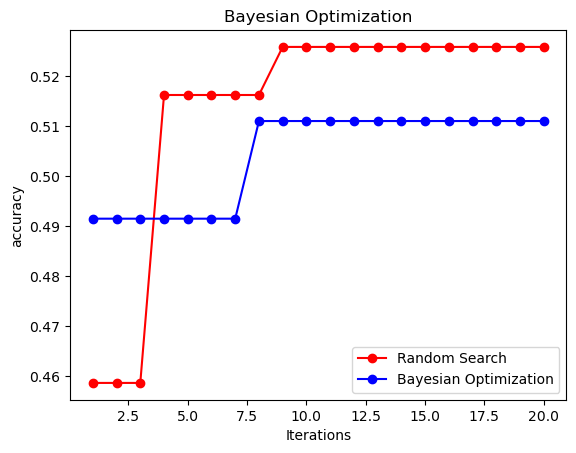

In [27]:
## comparison between random search and bayesian optimization
## we can plot the maximum oob per iteration of the sequence

# collect the maximum each iteration of BO
y_bo = np.maximum.accumulate(-opt_bo.func_vals).ravel()
y_random = np.maximum.accumulate(-opt_random.func_vals).ravel()
# define iteration number
xs = range(1, len(y_bo) + 1)

plt.plot(xs, y_random, 'o-', color = 'red', label='Random Search')
plt.plot(xs, y_bo, 'o-', color = 'blue', label='Bayesian Optimization')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('accuracy')
plt.title('Bayesian Optimization')
plt.show()

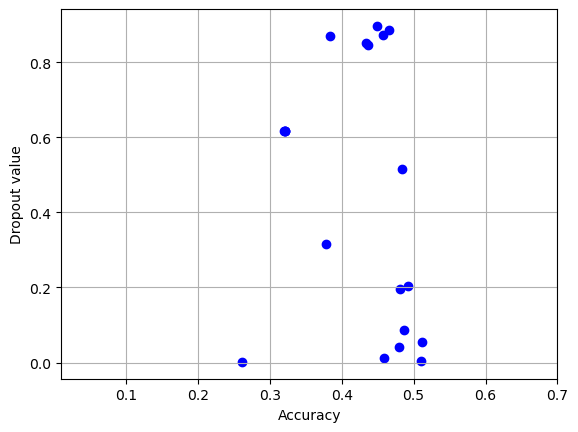

In [28]:
#print(opt_bo.func_vals.min(), opt_bo.func_vals.max())
#print(min(opt_bo.x_iters), max(opt_bo.x_iters))
opt_bo.x_iters = np.array(opt_bo.x_iters)
# depending if there is 2 or 1 parameter base on global params
if not (len(global_params) == 1 and global_params.get('module__base_channels') is not None):
    if len(global_params) == 2:
        plt.scatter(np.abs(opt_bo.func_vals), opt_bo.x_iters[:,1], color='blue')
    else:
        plt.scatter(np.abs(opt_bo.func_vals), opt_bo.x_iters, color='blue')
    plt.xlabel("Accuracy")
    plt.xlim(0.01, 0.7)
    plt.ylabel("Dropout value")
    plt.grid()
    plt.show()

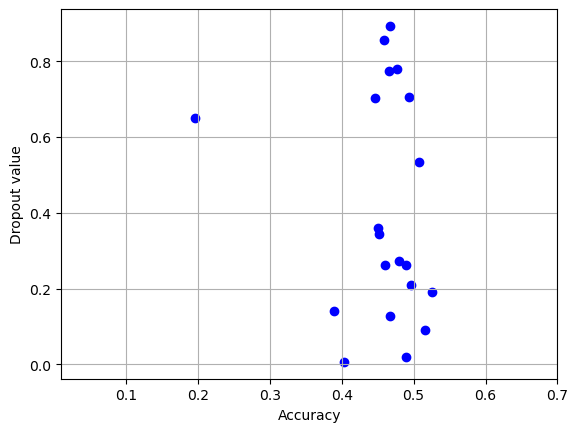

In [29]:
opt_random.x_iters = np.array(opt_random.x_iters)

if not (len(global_params) == 1 and global_params.get('module__base_channels') is not None):
    if len(global_params) == 2:
        plt.scatter(np.abs(opt_random.func_vals), opt_random.x_iters[:,1], color='blue')
    else:
        plt.scatter(np.abs(opt_random.func_vals), opt_random.x_iters, color='blue')
    plt.xlabel("Accuracy")
    plt.xlim(0.01, 0.7)
    plt.ylabel("Dropout value")
    plt.grid()
    plt.show()

In [31]:
if 'module__base_channels' in global_params.keys() and len(global_params) == 1:
    
    numebr_of_points = 1000
    # Create a grid for module__base_channels ranging from 1 to 256
    base_channels = np.linspace(base_channels_min, base_channels_max, numebr_of_points).reshape(-1, 1)
    # Transform the grid to normalized space using skopt's transform function
    x_norm = opt_bo.space.transform(base_channels)

    # Predict using the surrogate model built on the normalized space
    f_pred, f_std = opt_bo.models[-1].predict(x_norm, return_std=True)
    # Convert predictions from negative accuracy to accuracy
    acc_pred = -f_pred
    ci_lower = acc_pred - 1.96 * f_std
    ci_upper = acc_pred + 1.96 * f_std

    # Get the evaluated (checked) points and their observed values (convert to accuracy)
    x_points = np.array([pt[0] for pt in opt_bo.x_iters])
    y_points = -np.array(opt_bo.func_vals)

    plt.plot(base_channels, acc_pred, "r--", label="Surrogate model")
    plt.fill_between(base_channels.flatten(), ci_lower.flatten(), ci_upper.flatten(), color="r", alpha=0.2, label="95% CI")
    plt.scatter(x_points, y_points, c="black", zorder=5, label="Checked points")
    plt.xlabel("module__base_channels")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


In [32]:

if 'module__dropout' in global_params.keys()   and len(space) == 1:
    numebr_of_points = 1000
    # Create a grid for module__dropout ranging from dropout_min to dropout_max
    dropout_values = np.linspace(dropout_min, dropout_max, numebr_of_points).reshape(-1, 1)
    # Transform the grid to normalized space using skopt's transform function
    x_norm = opt_bo.space.transform(dropout_values)

    # Predict using the surrogate model built on the normalized space
    f_pred, f_std = opt_bo.models[-1].predict(x_norm, return_std=True)
    # Convert predictions from negative accuracy to accuracy
    acc_pred = -f_pred
    ci_lower = acc_pred - 1.96 * f_std
    ci_upper = acc_pred + 1.96 * f_std

    # Get the evaluated (checked) points and their observed values (convert to accuracy)
    x_points = np.array([pt[0] for pt in opt_bo.x_iters])
    y_points = -np.array(opt_bo.func_vals)

    plt.plot(dropout_values, acc_pred, "r--", label="Surrogate model")
    plt.fill_between(dropout_values.flatten(), ci_lower.flatten(), ci_upper.flatten(), color="r", alpha=0.2, label="95% CI")
    plt.scatter(x_points, y_points, c="black", zorder=5, label="Checked points")
    plt.xlabel("module__dropout")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()


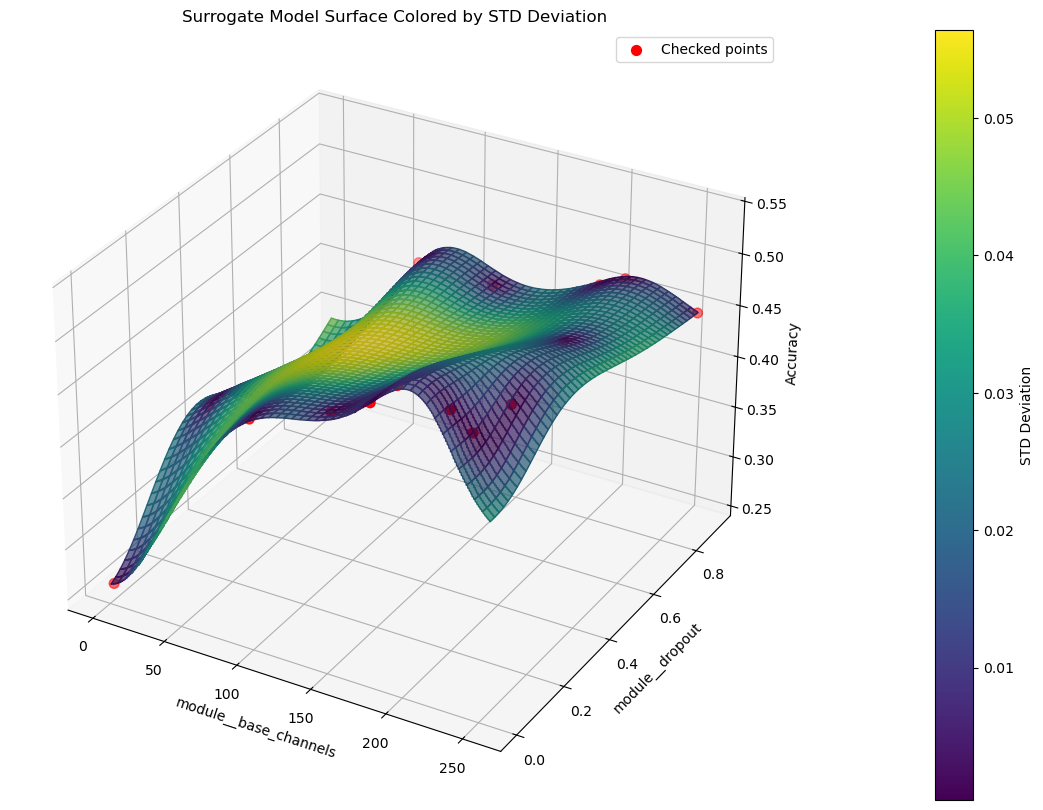

In [33]:
from mpl_toolkits.mplot3d import Axes3D

if len(space) == 2:
    numebr_of_points = 1000
    grid_bc = np.linspace(base_channels_min, base_channels_max, numebr_of_points)
    grid_dropout = np.linspace(dropout_min, dropout_max, numebr_of_points)
    X, Y = np.meshgrid(grid_bc, grid_dropout)

    # Stack and reshape the grid into (num_points, 2)
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T

    # Transform the grid into normalized space
    x_norm_grid = opt_bo.space.transform(grid_points)

    # Predict using the surrogate model
    f_pred, std_pred = opt_bo.models[-1].predict(x_norm_grid, return_std=True)
    Z = (-f_pred).reshape(X.shape)
    std_grid = std_pred.reshape(X.shape)

    fig = plt.figure(figsize=(20, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Normalize std values and map them to colors
    norm = plt.Normalize(vmin=std_grid.min(), vmax=std_grid.max())
    surf = ax.plot_surface(
        X, Y, Z,
        facecolors=plt.cm.viridis(norm(std_grid)),
        alpha=0.7
    )
    
    # Add a colorbar for the standard deviation
    mappable = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    mappable.set_array(std_grid)
    plt.colorbar(mappable, ax=ax, pad=0.1, label='STD Deviation')

    # Plot the evaluated points
    x_checked = opt_bo.x_iters[:,0]
    y_checked = opt_bo.x_iters[:,1]
    z_checked = -np.array(opt_bo.func_vals)
    ax.scatter(x_checked, y_checked, z_checked, color='red', s=50, label="Checked points")

    ax.set_xlabel("module__base_channels")
    ax.set_ylabel("module__dropout")
    ax.set_zlabel("Accuracy")
    ax.set_title("Surrogate Model Surface Colored by STD Deviation")
    ax.legend()
    plt.show()